## Asteroid 2024 YR4 Close Approach 2032 

This notebook calculates the orbit of asteroid 2024 YR4 up to its close approach with Earth on December 22, 2032. The integration is done with the [ASSIST package](https://assist.readthedocs.io/en/latest/installation/) which itself uses the general integrator code [REBOUND](https://rebound.readthedocs.io/en/latest/). To run this notebook, you will need to install ASSIST and download the associated ephemeris files for the major planets and asteroids (see the linked Github page). Note that these files are quite large ~ 1 GB.  

General information: [Wikipedia page](https://en.wikipedia.org/wiki/2024_YR4#)

JPL data: [2024 YR4](https://ssd.jpl.nasa.gov/tools/sbdb_lookup.html#/?sstr=2024%20YR4)

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import rebound
import assist 
from datetime import date, timedelta

# Load in Solar System ephemeris data
ephem = assist.Ephem("/home/jonnyp/data/linux_p1550p2650.440", "/home/jonnyp/data/sb441-n16.bsp")

In the cell below, the initial conditions of the asteroid's orbit are constructed in the approriate units. The asteroid initial conditions were retrieved for Feb 24, 2025 from the [JPL Horizons System](https://ssd.jpl.nasa.gov/horizons/app.html#/). 

In [3]:
print(f'{ephem.jd_ref}')

2451545.0


In [23]:
start_date = date(2025, 5, 20)

t_initial_jd = 2460815.500000000   
t_initial = t_initial_jd - ephem.jd_ref # Julian Days relative to jd_ref

G: float = 6.67430e-11  # MKS units 
AU: float = 1.495978707e11 # Meters
Days_to_Sec: int = 86400 

# 2.2e08 kg as current estimate
G_to_AU_Day = G * AU**-3 * Days_to_Sec**2   
asteroid_2024yr4_m = 2.2e8 * G_to_AU_Day    # standard gravitational parameter in AU/Day units

coords_km = {
    "x": -3.354943801342797E+08,
    "y": 5.519907701928559E+07,
    "z": -1.982857745322692E+07
}

vel_km_s = {
    "vx": -1.594232600307670E+01,
    "vy": -1.313784732284077E+01,
    "vz": -9.687694032548384E-01
}

""" 2/24
coords_km = {
    "x": -1.812544240535479E+08,
    "y": 1.394067867640291E+08,
    "z": -1.051895475872052E+07
}

vel_km_s = {
    "vx": -2.714464924696405E+01,
    "vy": -8.229050505628194E+00,
    "vz": -1.628778856972595E+00
}
"""

coords_au = {}
vel_au_d = {}

for k, v in coords_km.items():
    coords_au[k] = v * 1000 / AU
for k, v in vel_km_s.items():
    vel_au_d[k] = v * 1000 * Days_to_Sec / AU

print(coords_au)
print(vel_au_d)

asteroid_initial = rebound.Particle(m = asteroid_2024yr4_m, **coords_au, **vel_au_d)

{'x': -2.2426414130390406, 'y': 0.36898303940422056, 'z': -0.13254585349674314}
{'vx': -0.00920746371736845, 'vy': -0.00758774174647021, 'vz': -0.0005595111484512461}


Simulation setup occurs here. Integration is done with the Sun, major planets, and 16 major asteroids. Relativsitc corrections are included. Non-gravitational forces are not included at this time as exact parameters are unknown 

In [24]:
sim = rebound.Simulation()
sim.add(asteroid_initial)
sim.t = t_initial 
sim.ri_ias15.min_dt = 0.001  # Step size for IAS15 integrator 
extras = assist.Extras(sim, ephem)
extras.gr_eih_sources = 11   # Turn on GR for Sun and all planets

In [25]:
# Run the simulation!
t_final = t_initial + 3100 
N_samples = 500000
times = np.linspace(t_initial, t_final, N_samples, endpoint=True)

distances = np.zeros(N_samples)
asteroid_pos = np.zeros((N_samples, 3))
earth_pos = np.zeros((N_samples, 3))
for i, t in enumerate(times):
    extras.integrate_or_interpolate(t)
    asteroid_pos[i] = sim.particles[0].xyz
    earth_pos[i] = ephem.get_particle("earth", t).xyz
    dp = asteroid_pos[i] - earth_pos[i]  
    distances[i] = np.sqrt(dp[0]*dp[0]+dp[1]*dp[1]+dp[2]*dp[2])

Distance of closest approach: 49223008.36 Km (0.32904 AU)
Date of closest approach: 2028-11-17


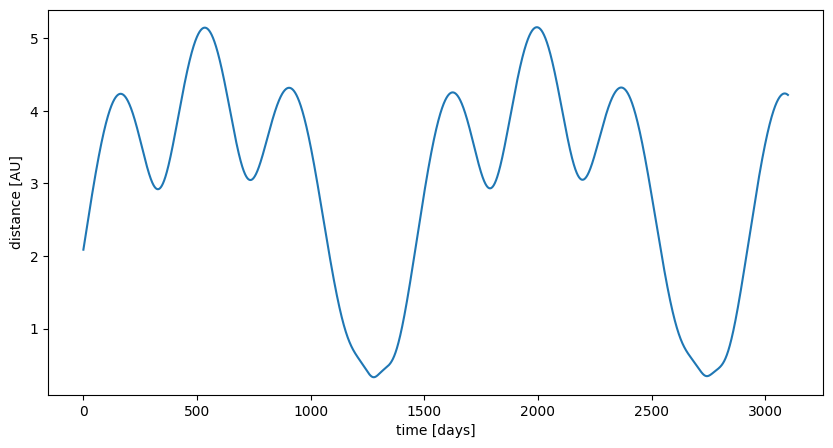

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.set_xlabel("time [days]")
ax.set_ylabel("distance [AU]")
plt.plot(times - times[0], distances);

# Calculate date of closest approach and distance 
dist_close = np.min(distances)
dist_close_km = dist_close * (AU / 1000)
min_idx = np.argmin(distances, axis=0)
print(f'Distance of closest approach: {dist_close_km:.2f} Km ({dist_close:.5f} AU)')
time_close = times[min_idx]-times[0]

end_date = start_date + timedelta(days= time_close)
print(f'Date of closest approach: {end_date}')

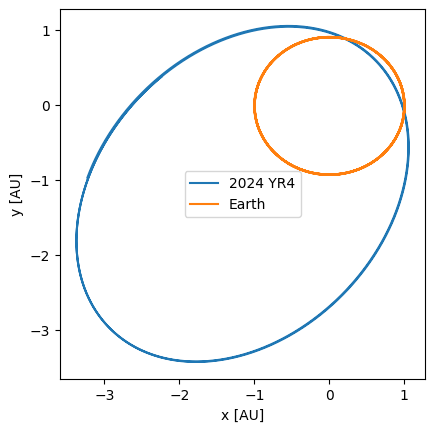

In [27]:
# Orbital plot
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlabel("x [AU]"); ax.set_ylabel("y [AU]")
ax.plot(asteroid_pos[:,0],asteroid_pos[:,1], label="2024 YR4")
ax.plot(earth_pos[:,0],earth_pos[:,1], label="Earth")
ax.legend();